<a href="https://colab.research.google.com/github/iakovkh/mypython/blob/main/LSTM_example23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

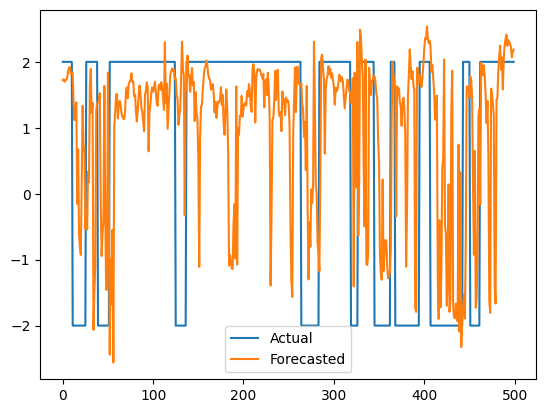

Correlation between forecasted and actual values: 0.34520995211826244


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Configuration section
data_file_name = '/content/sample_data/NN_cut.xlsx'
validate_file_name = '/content/sample_data/NN_contol_0.xlsx'
actual_file_name = '/content/sample_data/NN_contol.xlsx'
output_file_name = 'output.xlsx'
normalize = False
train_ratio = 0.8
number_of_layers = 5
number_of_neurons = 7
optimizer_name = 'adam'  # Other options: 'sgd', 'rmsprop', etc.
loss_function_name = 'mean_squared_error'  # Other options: 'mean_absolute_error', etc.
activation_function_name = 'relu'  # Other options: 'sigmoid', 'tanh', etc.
epochs = 500
adaptive_learning_rate = True

# Step I - General data preparation
class MyMatrix:
    def __init__(self):
        self.data = None

    def read_data_from_file(self, file_name):
        self.data = pd.read_excel(file_name)

    def normalize_data(self):
        scaler = MinMaxScaler()
        self.data = pd.DataFrame(scaler.fit_transform(self.data), columns=self.data.columns)

    def display_console(self, column=None):
        if column:
            print(self.data[column])
        else:
            print(self.data)

    def display_visual(self, column=None):
        if column:
            self.data[column].plot()
            plt.show()
        else:
            self.data.plot(subplots=True)
            plt.show()

# Step II - Read and prepare data
MyData = MyMatrix()
MyData.read_data_from_file(data_file_name)

if normalize:
    MyData.normalize_data()

train_data, test_data = train_test_split(MyData.data, train_size=train_ratio, shuffle=False)

# Step III - Design the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(self.get_activation_function())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(self.get_activation_function())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def get_activation_function(self):
        if activation_function_name == 'relu':
            return nn.ReLU()
        elif activation_function_name == 'sigmoid':
            return nn.Sigmoid()
        elif activation_function_name == 'tanh':
            return nn.Tanh()
        else:
            raise ValueError("Unsupported activation function")

input_size = train_data.shape[1] - 1
hidden_size = number_of_neurons
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size, number_of_layers)

if optimizer_name == 'adam':
    optimizer = optim.Adam(model.parameters())
elif optimizer_name == 'sgd':
    optimizer = optim.SGD(model.parameters())
elif optimizer_name == 'rmsprop':
    optimizer = optim.RMSprop(model.parameters())
else:
    raise ValueError("Unsupported optimizer")

if loss_function_name == 'mean_squared_error':
    criterion = nn.MSELoss()
elif loss_function_name == 'mean_absolute_error':
    criterion = nn.L1Loss()
else:
    raise ValueError("Unsupported loss function")

# Step III.4 - Train the network
train_X = torch.tensor(train_data.iloc[:, 1:].values, dtype=torch.float32)
train_Y = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.float32).view(-1, 1)
test_X = torch.tensor(test_data.iloc[:, 1:].values, dtype=torch.float32)
test_Y = torch.tensor(test_data.iloc[:, 0].values, dtype=torch.float32).view(-1, 1)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_X)
    loss = criterion(outputs, train_Y)
    loss.backward()
    optimizer.step()

# Step IV - Testing results
model.eval()
predicted = model(test_X).detach().numpy()
actual = test_Y.numpy()

# Save the results
output_df = pd.DataFrame({'Forecasted': predicted.flatten(), 'Actual': actual.flatten()})
output_df.to_excel(output_file_name, index=False)

# Visualize the results
plt.plot(output_df['Actual'], label='Actual')
plt.plot(output_df['Forecasted'], label='Forecasted')
plt.legend()
plt.show()

# Calculate and print correlation
correlation = output_df.corr().iloc[0, 1]
print(f'Correlation between forecasted and actual values: {correlation}')
